In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scqubits
from functools import partial
import qutip
import concurrent
from loky import get_reusable_executor
import numpy as np
import qutip
import scqubits
from typing import List, Union,Any

from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.drive import *
from CoupledQuantumSystems.evo import ODEsolve_and_post_process
from CoupledQuantumSystems.noise import *
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.IFQ import gfIFQ


In [5]:
from scipy.optimize import minimize

EJ = 4
EC = EJ/2.7
EL = EJ/45

qbt = gfIFQ(EJ = EJ,EC =EC,EL = EL,truncated_dim=11)

temp_in_mK = 20
loss_tangent_ref = 5e-6
one_over_f_flux_noise_amplitude = 1e-6

c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        loss_tangent_ref,
                        one_over_f_flux_noise_amplitude)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(11)]


In [6]:
from IPython.display import clear_output

t_duration = 200
tlist = np.linspace(0,t_duration,t_duration)
detuning = 0.3

[4.18224652 4.19404318 0.09563057 0.10334693]


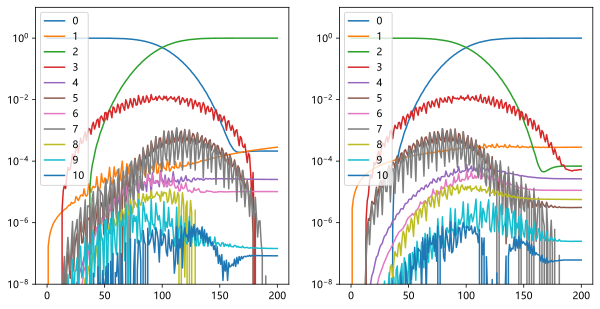

(0.00017342048204926908, 0.00017421823131391623)


In [8]:
def objective(x):
    amp1_scaling_factor = x[0]
    amp2_scaling_factor = x[1]
    amp1_correction_scaling_factor = x[2]
    amp2_correction_scaling_factor = x[3]
    results  = qbt.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(qbt.truncated_dim, 0),qutip.basis(qbt.truncated_dim, 2)],
        tlist = tlist,
        drive_terms = qbt.get_Raman_DRAG_drive_terms(
            i = 0,
            j = 3,
            k = 2,
            detuning1=detuning,
            detuning2 = detuning,
            t_duration=t_duration,
            shape='sin^2',
            amp_scaling_factor = 1,
            amp1_scaling_factor = amp1_scaling_factor,
            amp2_scaling_factor = amp2_scaling_factor,
            amp1_correction_scaling_factor = amp1_correction_scaling_factor,
            amp2_correction_scaling_factor = amp2_correction_scaling_factor,
        ),
        c_ops = c_ops,
        e_ops = e_ops
    )
    clear_output()
    print(x)
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()
    
    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1] + 0.98* results[0].expect[1][-1]))
    one_minus_pop0 = np.abs(1- (results[1].expect[0][-1] +  0.98* results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop0))
    return one_minus_pop2 + one_minus_pop0

initial_guess = [4.0,4.0 ,0.10174757, 0.10451909]




result = minimize(objective, initial_guess, method='Nelder-Mead')


In [7]:
def objective(x):
    
    amp1_scaling_factor = x[0]
    amp2_scaling_factor = x[1]
    amp1_correction_scaling_factor = x[2]
    amp2_correction_scaling_factor = x[3]
    detuning1 =x[4]
    detuning2 =x[5]
    results  = qbt.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(qbt.truncated_dim, 0),qutip.basis(qbt.truncated_dim, 2)],
        tlist = tlist,
        drive_terms = qbt.get_Raman_DRAG_drive_terms(
            i = 0,
            j = 3,
            k = 2,
            detuning1=detuning1,
            detuning2 = detuning2,
            t_duration=t_duration,
            shape='sin^2',
            amp_scaling_factor = 1,
            amp1_scaling_factor = amp1_scaling_factor,
            amp2_scaling_factor = amp2_scaling_factor,
            amp1_correction_scaling_factor = amp1_correction_scaling_factor,
            amp2_correction_scaling_factor = amp2_correction_scaling_factor,
        ),
        c_ops = c_ops,
        e_ops = e_ops
    )
    clear_output()
    print(x)
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()
    
    one_minus_pop2 = 1- (results[0].expect[2][-1] + 0.98* results[0].expect[1][-1])
    one_minus_pop0 = 1- (results[1].expect[0][-1] +  0.98* results[1].expect[1][-1])
    print((one_minus_pop2, one_minus_pop0))
    return one_minus_pop2 + one_minus_pop0

initial_guess = [2.19360814, 2.16602898, 0.10204908, 0.10411559,0.3,0.3]




result = minimize(objective, initial_guess, method='Nelder-Mead')


[2.1944419  2.16577895 0.10283758 0.1037343  0.30006241 0.30007084]


# what is idling error rate?